# XGBoost Regressor: Predicting NBA player's 2K25 overall rating

In [12]:
import numpy as np
import pandas as pd
import os

print(f'numpy version: {np.__version__}')
print(f'pandas version: {pd.__version__}')


tensorflow version: 2.13.0
numpy version: 1.23.5
pandas version: 1.5.3


# Load Data

The data's dimension is 521 x 104. 

In [2]:
data = pd.read_csv('~/Desktop/current_nba_players.csv').iloc[:,1:]
print(data.shape)
data.head(5)

(521, 104)


,name,nationality_1,nationality_2,team,jersey,position_1,position_2,archetype,height_feet,height_cm,...,badge_off_ball_pest,badge_on_ball_menace,badge_paint_patroller,badge_pick_dodger,badge_post_lockdown,badge_boxout_beast,badge_rebound_chaser,badge_brick_wall,badge_slippery_off_ball,badge_pogo_stick
0,Aaron Gordon,United States,NaN,Denver Nuggets,32.0,PF,NaN,2-Way Interior Scorer,"6'8""",203,...,silver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gold
1,Aaron Holiday,United States,NaN,Houston Rockets,0.0,PG,SG,Perimeter Shot Creator,"6'0""",183,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Aaron Nesmith,United States,NaN,Indiana Pacers,23.0,SF,PF,2-Way Catch & Shoot Ace,"6'5""",196,...,silver,NaN,NaN,NaN,NaN,NaN,NaN,NaN,silver,bronze
3,Aaron Wiggins,United States,NaN,Oklahoma City Thunder,21.0,PF,SF,Inside-Out Scoring Threat,"6'5""",196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,gold,NaN
4,Adam Flagler,United States,NaN,Oklahoma City Thunder,14.0,SG,PG,Catch & Shoot Threat,"6'3""",191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing

In [3]:
# drop inital trash columns
irrelavant_columns = ['nationality_2', 'archetype', 'hometown', 'prior_to_nba', 'birthdate', 'position_2',
                      'height_feet', 'weight_kg', 'wingspan_feet']
data = data.drop(columns=irrelavant_columns, index=1)


In [4]:
# drop non-NBA players
data = data.dropna(subset=['team', 'jersey'])

In [5]:
# fill season_salary and agility with mean value
columns_fill_mean = ['season_salary', 'agility']
data[columns_fill_mean] = data[columns_fill_mean].apply(lambda x: x.fillna(x.mean()))

In [6]:
# label encoding for badges
encoding = {'bronze':1, 'silver':2, 'gold':3, 'hof':4}

data.iloc[:,55:] = data.iloc[:,55:].apply(lambda x: x.map(encoding))
data.iloc[:,55:] = data.iloc[:,55:].apply(lambda x: x.fillna(0))


/var/folders/q0/_1zxr2j52js_c6dlq88y4w1c0000gn/T/ipykernel_36104/221239521.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data.iloc[:,55:] = data.iloc[:,55:].apply(lambda x: x.map(encoding))


In [7]:
# one-hot encoding for position
data = pd.get_dummies(data, columns=['position_1'])

In [8]:
# stadardize measurements
from sklearn.preprocessing import StandardScaler

scaler_columns = ['height_cm', 'weight_lbs', 'wingspan_cm']
st_scaler = StandardScaler()
data[scaler_columns] = st_scaler.fit_transform(data[scaler_columns])

In [9]:
# standardize salary
from sklearn.preprocessing import RobustScaler 

rb_scaler = RobustScaler()
data[['season_salary']] = rb_scaler.fit_transform(data[['season_salary']])

# Model Training

In [10]:
X = data.drop(columns=['name', 'nationality_1', 'team', 'jersey', 'overall'], axis = 1)
y = data['overall']

from sklearn.model_selection import train_test_split

# split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23)

## Inital Training

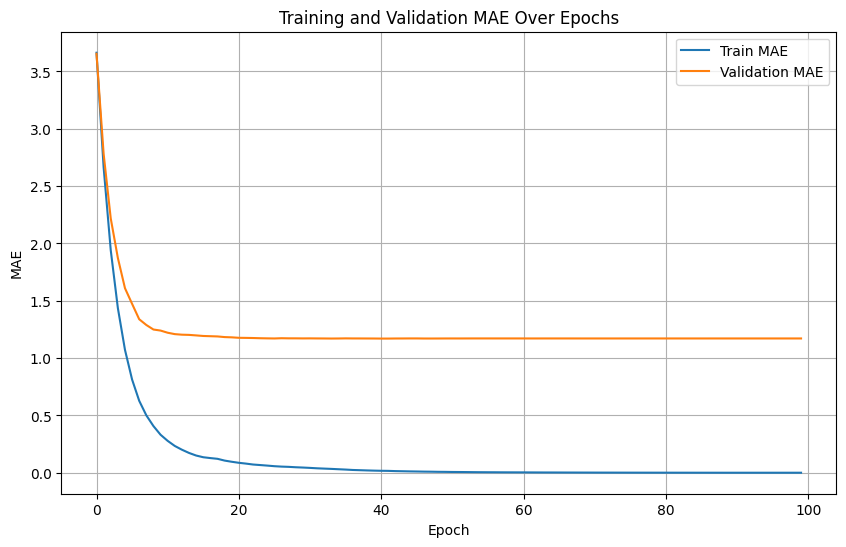

Overall Test MAE: 1.1715042701134315


In [38]:
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


# Set up the XGBoost model with evaluation metric
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric="mae",
    random_state = 23
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Retrieve the evaluation results after training
evals_result = xgb_model.evals_result()

# Plotting the training and validation RMSE
epochs = len(evals_result['validation_0']['mae'])
x_axis = range(epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['validation_0']['mae'], label='Train MAE')
plt.plot(x_axis, evals_result['validation_1']['mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Overall Test MAE:", mae)

## The initial training has a Mean Absolute Error of 1.172, which is not bad at all. Now let us use GridSearch to finetune the model

In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'alpha': [0, 0.5, 1, 1.5],  # L1 regularization
    'lambda': [1, 1.5, 2, 2.5]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', random_state=23)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=3, verbose=1, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with the best parameters
best_xgb_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
best_xgb_model.fit(X_train, y_train)

# Predict and calculate MAE on the test set
y_pred = best_xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error with Optimal Parameters:", mae)



Fitting 3 folds for each of 32000 candidates, totalling 96000 fits
Best Parameters: {'alpha': 0, 'colsample_bytree': 0.6, 'lambda': 1, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 400, 'subsample': 0.6}
Mean Absolute Error with Optimal Parameters: 0.9506945096529447


## Final Model 

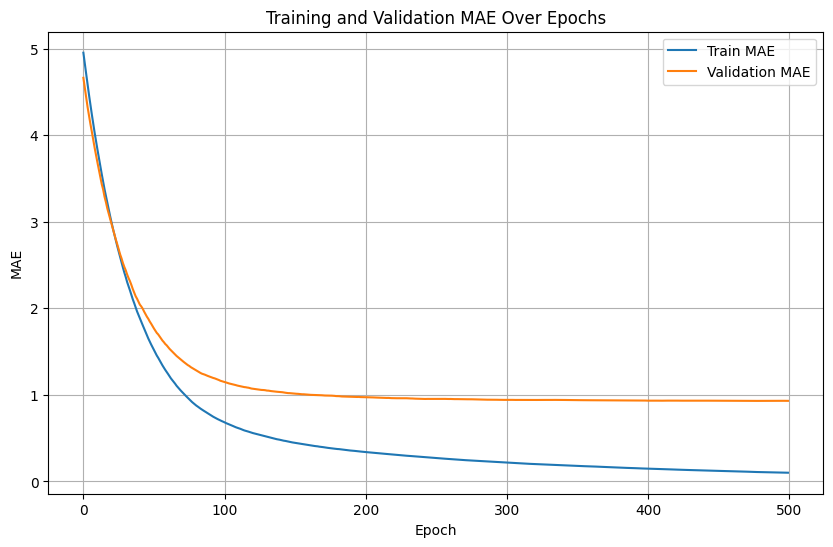

Overall Test MAE: 0.9


In [67]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric="mae",
    random_state = 23,
    learning_rate = 0.03,
    max_depth = 4,
    n_estimators = 500,
    subsample = 0.6,
    colsample_bytree = 0.6,
    reg_alpha = 0,  # L1 regularization
    reg_lambda = 1  # L2 regularization
)


xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)

# Retrieve the evaluation results after training
evals_result = xgb_model.evals_result()

# Plotting the training and validation RMSE
epochs = len(evals_result['validation_0']['mae'])
x_axis = range(epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, evals_result['validation_0']['mae'], label='Train MAE')
plt.plot(x_axis, evals_result['validation_1']['mae'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Training and Validation MAE Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

y_pred = xgb_model.predict(X_test)
mae = mean_absolute_error(y_test, np.rint(y_pred).astype(int))
print("Overall Test MAE:", mae)




# Conclustion

## Final model achieved Mean Absolute Error of 0.9. We can interpret it as -- on average, the model predictions are off by 0.9 rating points from the actual ratings when predicting a NBA player's overall rating in NBA 2K25.

In [94]:

pd.DataFrame({
    'Player Name': data.loc[X_test.index, 'name'],
    'Overall':y_test,
    'Predicted Overall':np.rint(y_pred).astype(int),
}
)



,Player Name,Overall,Predicted Overall
414,Pelle Larsson,68,68
370,Mitchell Robinson,80,78
234,Jaylen Brown,92,91
204,Jake LaRavia,74,75
378,Bones Hyland,74,75
...,...,...,...
194,Jabari Smith Jr.,80,80
424,Quinten Post,68,68
62,Buddy Hield,79,76
272,Josh Christopher,70,74
